In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import umap
from sklearn.decomposition import PCA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_num = 134

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()
pro_s1d2 = pro_s1d2.X.toarray()
pro_s1d3 = pro_s1d3.X.toarray()
pro_s2d1 = pro_s2d1.X.toarray()
pro_s2d4 = pro_s2d4.X.toarray()
pro_s2d5 = pro_s2d5.X.toarray()

pro_s3d1 = pro_s3d1.X.toarray()
pro_s3d6 = pro_s3d6.X.toarray()
pro_s3d7 = pro_s3d7.X.toarray()

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()
pro_s4d8 = pro_s4d8.X.toarray()
pro_s4d9 = pro_s4d9.X.toarray()

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 134)


In [17]:
print(RNA_s4d1.shape)
print(pro_s4d1.shape)

(334, 13953)
(334, 134)


In [18]:
print(RNA_s4d8.shape)
print(pro_s4d8.shape)

(207, 13953)
(207, 134)


In [19]:
print(RNA_s4d9.shape)
print(pro_s4d9.shape)

(459, 13953)
(459, 134)


In [20]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [21]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [22]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [23]:
# # standardize based on each batch
# for i in range(len(train_input)):
#     train_input[i] = (train_input[i]-np.mean(train_input[i]))/np.std(train_input[i])

# for i in range(len(train_output)):
#     train_output[i] = (train_output[i]-np.mean(train_output[i]))/np.std(train_output[i])

# for i in range(len(val_input)):
#     val_input[i] = (val_input[i]-np.mean(val_input[i]))/np.std(val_input[i])

# for i in range(len(val_output)):
#     val_output[i] = (val_output[i]-np.mean(val_output[i]))/np.std(val_output[i])

In [24]:
train_input = train_input + val_input
train_output = train_output + val_output

In [25]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [26]:
print(train_input.shape)
print(val_input.shape)
print(test_input.shape)

(66175, 13953)
(28921, 13953)
(1000, 13953)


In [27]:
pca = PCA(n_components=3000)
pca.fit(train_input)
# print(pca.explained_variance_ratio_)

PCA(copy=True, iterated_power='auto', n_components=3000, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [28]:
train_input = np.matmul(train_input, pca.components_.transpose())
val_input = np.matmul(val_input, pca.components_.transpose())
test_input = np.matmul(test_input, pca.components_.transpose())

In [29]:
print(train_input.shape)
print(val_input.shape)
print(test_input.shape)

(66175, 3000)
(28921, 3000)
(1000, 3000)


In [30]:
# train_input = (train_input - np.reshape(np.mean(train_input, 1), (train_input.shape[0], 1)))/np.reshape(np.std(train_input, 1), (train_input.shape[0], 1))
# val_input = (val_input - np.reshape(np.mean(val_input, 1), (val_input.shape[0], 1)))/np.reshape(np.std(val_input, 1), (val_input.shape[0], 1))
# test_input = (test_input - np.reshape(np.mean(test_input, 1), (test_input.shape[0], 1)))/np.reshape(np.std(test_input, 1), (test_input.shape[0], 1))

In [31]:
train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)
val_input = torch.from_numpy(val_input)
val_output = torch.from_numpy(val_output)
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [32]:
train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()
test_input = test_input.float()
test_output = test_output.float()

In [33]:
train_input = train_input.to(device)
train_output = train_output.to(device)
val_input = val_input.to(device)
val_output = val_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

In [34]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_train)):
    if batch_train[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_train[i]] = k
    batch_train[i] = batch_lib[batch_train[i]]

In [35]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_val)):
    if batch_val[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_val[i]] = k
    batch_val[i] = batch_lib[batch_val[i]]

In [36]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_test)):
    if batch_test[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_test[i]] = k
    batch_test[i] = batch_lib[batch_test[i]]

In [37]:
batch_train = batch_train + batch_val

In [38]:
train_output = train_output[:, 0:pred_num]
train_output.shape

torch.Size([66175, 134])

In [39]:
val_output = val_output[:, 0:pred_num]
val_output.shape

torch.Size([28921, 134])

In [40]:
test_output = test_output[:, 0:pred_num]
test_output.shape

torch.Size([1000, 134])

In [41]:
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

In [42]:
input_feature = train_input.shape[1]
output_feature = pred_num

In [43]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//32)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//4)
        self.linear4 = nn.Linear(input_feature//4, input_feature//8)
        self.linear5 = nn.Linear(input_feature//8, input_feature//16)
        self.linear6 = nn.Linear(input_feature//16, input_feature//32)
        
        self.linear7 = nn.Linear(input_feature//32, pred_num)
        
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, pred_num)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # x = self.linear2(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
#         x = self.linear5(x)
#         x = self.relu(x)
        
#         x = self.linear6(x)
#         x = self.relu(x)
        
        output = self.linear7(x)
        
        return output.float()

In [44]:
PATH = 'Sample_norm_model_pca'

In [45]:
def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
    # plt.rcParams['figure.figsize'] = [40, 40]
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            # print(y.shape, pred.shape)
            # y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            train_pred = model(train_input)
            # train_output = torch.reshape(train_output, (train_output.shape[0], 1))
            train_loss = loss_fn(train_pred, train_output)
            train_loss = torch.sqrt(train_loss)
            train_loss = train_loss.cpu().detach().numpy()
            
            val_pred = model(val_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            val_loss = loss_fn(val_pred, val_output)
            val_loss = torch.sqrt(val_loss)
            val_loss = val_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            test_loss = loss_fn(test_pred, test_output)
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
            if val_loss < val_best:
                torch.save(model.state_dict(), PATH)
                val_best = val_loss
                
            print('Epoch ', epoch, 'Train_loss: ', train_loss, ' Validation_loss: ', val_loss, ' Test_loss: ', test_loss)
        if epoch % 2000 == 0:
            colors = ['red','green','blue','purple', 'yellow', 'orange']
            figure, ax = plt.subplots(1, 3, figsize = (13, 3*1))
            for i in range(1):
                ax[0].scatter(train_output.cpu().detach().numpy()[:, 0], train_pred.cpu().detach().numpy()[:, 0], c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Train data result ' + str(i+1))
                ax[0].set_xlabel('train')
                ax[0].set_ylabel('pred')

                ax[1].scatter(val_output.cpu().detach().numpy()[:, 0], val_pred.cpu().detach().numpy()[:, 0], c=batch_val, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('Validation data result ' + str(i+1))
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(test_output.cpu().detach().numpy()[:, 0], test_pred.cpu().detach().numpy()[:, 0], c=batch_test, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('Test data result ' + str(i+1))
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
            
            plt.show()
            # train_pred_output.append([train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy()])
            # val_pred_output.append([val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()])
    return train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy(), val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()

In [46]:
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss

In [47]:
# num_epochs = 50000
# model = Autoencoder()
# # model.load_state_dict(torch.load(PATH))
# model = model.to(device)
# # model.eval()

# def seed_everything(seed=1234):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True

# seed_everything()
    
# opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)

Epoch  0 Train_loss:  0.9247638  Validation_loss:  0.7905786  Test_loss:  1.0782658


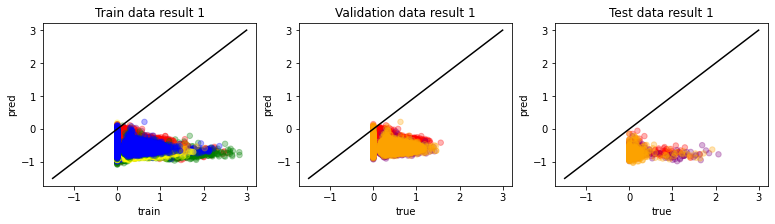

Epoch  100 Train_loss:  0.38925081  Validation_loss:  0.33072364  Test_loss:  0.46680915
Epoch  200 Train_loss:  0.36413333  Validation_loss:  0.31368527  Test_loss:  0.43924373
Epoch  300 Train_loss:  0.35777518  Validation_loss:  0.30974883  Test_loss:  0.4350405
Epoch  400 Train_loss:  0.35370085  Validation_loss:  0.30736417  Test_loss:  0.4336926
Epoch  500 Train_loss:  0.35084984  Validation_loss:  0.30562195  Test_loss:  0.43303272
Epoch  600 Train_loss:  0.3480197  Validation_loss:  0.30336317  Test_loss:  0.43197745
Epoch  700 Train_loss:  0.3464673  Validation_loss:  0.30217102  Test_loss:  0.43171984
Epoch  800 Train_loss:  0.3453556  Validation_loss:  0.30106944  Test_loss:  0.4312614
Epoch  900 Train_loss:  0.34312195  Validation_loss:  0.2997562  Test_loss:  0.4307411
Epoch  1000 Train_loss:  0.34220803  Validation_loss:  0.29944468  Test_loss:  0.4307298
Epoch  1100 Train_loss:  0.3405959  Validation_loss:  0.2987533  Test_loss:  0.43078578
Epoch  1200 Train_loss:  0.340

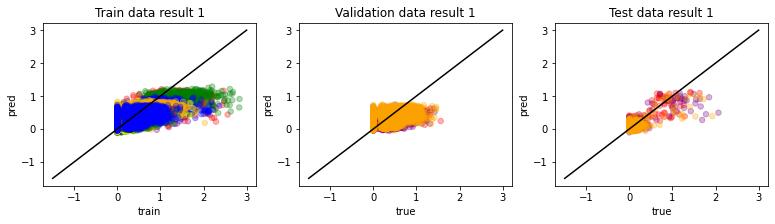

Epoch  2100 Train_loss:  0.3336984  Validation_loss:  0.2954797  Test_loss:  0.42922482
Epoch  2200 Train_loss:  0.33335853  Validation_loss:  0.2952927  Test_loss:  0.42868176
Epoch  2300 Train_loss:  0.33288154  Validation_loss:  0.2947784  Test_loss:  0.42806527
Epoch  2400 Train_loss:  0.3317792  Validation_loss:  0.29471394  Test_loss:  0.42993972
Epoch  2500 Train_loss:  0.33132407  Validation_loss:  0.29450834  Test_loss:  0.42987412
Epoch  2600 Train_loss:  0.3315642  Validation_loss:  0.29411674  Test_loss:  0.42814678
Epoch  2700 Train_loss:  0.33084106  Validation_loss:  0.29414874  Test_loss:  0.42944562
Epoch  2800 Train_loss:  0.33024788  Validation_loss:  0.29378143  Test_loss:  0.42966244
Epoch  2900 Train_loss:  0.32974195  Validation_loss:  0.29363525  Test_loss:  0.43049076
Epoch  3000 Train_loss:  0.3297051  Validation_loss:  0.29367554  Test_loss:  0.4295322
Epoch  3100 Train_loss:  0.32982954  Validation_loss:  0.29314396  Test_loss:  0.42854473
Epoch  3200 Train_

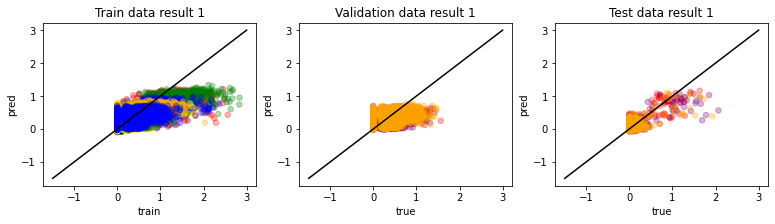

Epoch  4100 Train_loss:  0.32759732  Validation_loss:  0.2917316  Test_loss:  0.42800373
Epoch  4200 Train_loss:  0.32704514  Validation_loss:  0.29167694  Test_loss:  0.428808
Epoch  4300 Train_loss:  0.32684892  Validation_loss:  0.29189527  Test_loss:  0.4290827
Epoch  4400 Train_loss:  0.32703006  Validation_loss:  0.29182467  Test_loss:  0.42880592
Epoch  4500 Train_loss:  0.3269699  Validation_loss:  0.291466  Test_loss:  0.42825148
Epoch  4600 Train_loss:  0.32686073  Validation_loss:  0.29129016  Test_loss:  0.42801446
Epoch  4700 Train_loss:  0.32699367  Validation_loss:  0.29151267  Test_loss:  0.42789355
Epoch  4800 Train_loss:  0.3262913  Validation_loss:  0.29123056  Test_loss:  0.42868212
Epoch  4900 Train_loss:  0.32651868  Validation_loss:  0.29137546  Test_loss:  0.4284862
Epoch  5000 Train_loss:  0.32662904  Validation_loss:  0.29139546  Test_loss:  0.42844528
Epoch  5100 Train_loss:  0.32622144  Validation_loss:  0.29118937  Test_loss:  0.42908743
Epoch  5200 Train_l

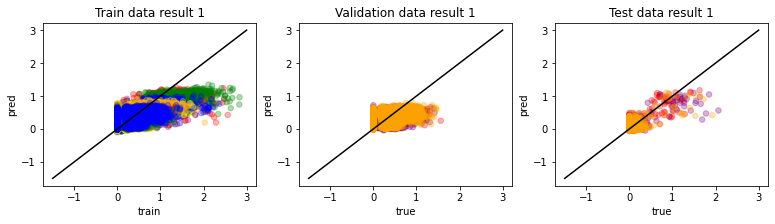

Epoch  6100 Train_loss:  0.32538074  Validation_loss:  0.29032993  Test_loss:  0.4295714
Epoch  6200 Train_loss:  0.32588628  Validation_loss:  0.29053771  Test_loss:  0.42861637
Epoch  6300 Train_loss:  0.32540783  Validation_loss:  0.29079318  Test_loss:  0.4298596
Epoch  6400 Train_loss:  0.32528847  Validation_loss:  0.2905211  Test_loss:  0.42945215
Epoch  6500 Train_loss:  0.32528663  Validation_loss:  0.2901284  Test_loss:  0.4287837
Epoch  6600 Train_loss:  0.32488498  Validation_loss:  0.2900521  Test_loss:  0.42958486
Epoch  6700 Train_loss:  0.32614693  Validation_loss:  0.2902906  Test_loss:  0.4281087
Epoch  6800 Train_loss:  0.3250484  Validation_loss:  0.29010522  Test_loss:  0.4292041
Epoch  6900 Train_loss:  0.3247673  Validation_loss:  0.28929585  Test_loss:  0.4291789
Epoch  7000 Train_loss:  0.3250797  Validation_loss:  0.28906405  Test_loss:  0.42866993
Epoch  7100 Train_loss:  0.3247452  Validation_loss:  0.28899223  Test_loss:  0.4290191
Epoch  7200 Train_loss:  

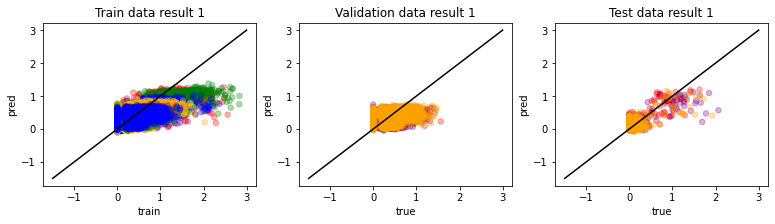

Epoch  8100 Train_loss:  0.3224871  Validation_loss:  0.28641996  Test_loss:  0.42680827
Epoch  8200 Train_loss:  0.32289064  Validation_loss:  0.2861865  Test_loss:  0.42569774
Epoch  8300 Train_loss:  0.3224184  Validation_loss:  0.28642327  Test_loss:  0.4266868
Epoch  8400 Train_loss:  0.3224787  Validation_loss:  0.28646475  Test_loss:  0.42609656
Epoch  8500 Train_loss:  0.32249764  Validation_loss:  0.28646463  Test_loss:  0.42626753
Epoch  8600 Train_loss:  0.32243633  Validation_loss:  0.2864292  Test_loss:  0.42664906
Epoch  8700 Train_loss:  0.32229042  Validation_loss:  0.28625134  Test_loss:  0.42667532
Epoch  8800 Train_loss:  0.32217485  Validation_loss:  0.2861337  Test_loss:  0.42680457
Epoch  8900 Train_loss:  0.32202697  Validation_loss:  0.28619167  Test_loss:  0.4272367
Epoch  9000 Train_loss:  0.32201824  Validation_loss:  0.28594705  Test_loss:  0.4270074
Epoch  9100 Train_loss:  0.32169068  Validation_loss:  0.28607193  Test_loss:  0.4280224
Epoch  9200 Train_lo

In [48]:
learning_rate = 0.1
latent_dim = 50
loss_fn = F.mse_loss

num_epochs = 10000
model = Autoencoder()
# model.load_state_dict(torch.load(PATH))
model = model.to(device)
# model.eval()

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)